### Homework 03
#### Benjamin Fry (bfry2@jhu.edu)
#### Advanced Seminar in Membrane Structure, Function, and Pharmacology
#### 09/27/21

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

### Question 1
Recreating Figure 5:
List all residues with corresponding free energy. Also record error bars into their own dict.

In [2]:
ddGsc = {"A": -1.73, "C": -2.45, "D": 0.77, "E": -0.54, "F": -4.17, "G": -0.09, "H": 1.60, "I": -3.90, "K": 1.81, "L": -3.74, "M": -2.88, 
         "N": 1.22, "P": 2.09, "Q": 0.81, "R": 1.49, "S": 0.11, "T": -0.78, "V": -3.48, "W": -3.93, "Y": -2.75}

ddGsc_err = { "A": 0.02, "C": 0.04, "D": 0.09, "E": 0.14, "F": 0.07, "G": 0.11, "H": 0.12, "I": 0.15, "K": 0.08, "L": 0.13, "M": 0.21, 
              "N": 0.03, "P": 0.07, "Q": 0.03, "R": 0.06, "S": 0.04, "T": 0.05, "V": 0.12, "W": 0.02, "Y": 0.28}


# sort by ddG
pairlist = list(ddGsc.items())
pairlist.sort(key = lambda x: x[1])
names = [x[0] for x in pairlist]
pairlist_error = [ddGsc_err[x] for x in names]
values = [x[1] for x in pairlist]

Grab the rgb values from figure 5 and convert them to pyplot range, associate each with residue for plot coloring

In [3]:
def convert(tup):
    #Pull RGB values from the paper to get same colors
    return (tup[0]/255, tup[1]/255, tup[2]/255)
    
grey = convert((99, 99, 99))
yellow = convert((245, 199, 49))
blue = convert((87, 103, 178))
orange = convert((215, 91, 46))

ddGsc_color = { "A": grey, "C": yellow, "D": blue, "E": blue, "F": grey, "G": yellow, "H": blue, "I": grey, "K": blue, "L": grey, "M": grey,  
               "N": orange, "P": grey, "Q": orange, "R": blue, "S": orange, "T": orange, "V": grey, "W": grey, "Y": grey}

Plot the energies as found in figure 5 with proper colors and erorr bars.

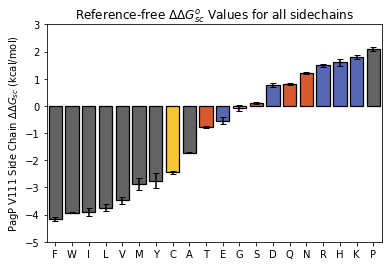

In [4]:
barlist = plt.bar(names, values, linewidth=1.25, edgecolor="black", yerr=pairlist_error, capsize=3)
for i, x in enumerate(names):
    barlist[i].set_color(ddGsc_color[x])
    barlist[i].set_ec("black")

plt.axis([-.5, 19.5, -5, 3])
plt.ylabel("PagP V111 Side Chain $\Delta \Delta G_{sc}$ (kcal/mol)");
plt.title("Reference-free $\Delta \Delta G^o_{sc}$ Values for all sidechains")
plt.show()

### Question 2

Create Gly_X_Gly peptides with Peptide Builder. Dumps the pdbs to ./peptides

In [5]:
!pip install PeptideBuilder
from PeptideBuilder import Geometry
import PeptideBuilder
import Bio.PDB

In [6]:
np_aas = ["A", "F", "I", "L", "M", "V"]

# create a peptide consisting of 6 glycines
for olc in np_aas:
    
    res = Geometry.geometry(olc)
    res.phi = -139
    res.psi_im1 = +135
    
    gly = Geometry.geometry("G")
    gly.phi = -139
    gly.psi_im1 = +135
    
    structure = PeptideBuilder.initialize_res(gly)
    PeptideBuilder.add_residue(structure, res)
    PeptideBuilder.add_residue(structure, gly)
    PeptideBuilder.add_terminal_OXT(structure)
    
    out = Bio.PDB.PDBIO()
    out.set_structure(structure)
    out.save(f"./peptides/gly_{olc}_gly.pdb")

Calculate Non-Polar SASA Scores for each guest residue and nonpolar atom in the peptide.

In [7]:
!pip install freesasa
import freesasa

In [8]:
nonpolar_pymol_selection = "(resi 2 and not name O and not name C and not name N) or name CA"
nonpolar_sasas = {}
for i in os.listdir("./peptides"):
    if i[-4:] == ".pdb":
        resname = i[:-4][4:][:-4]
        structure = freesasa.Structure("./peptides/"+i)
        result = freesasa.calc(structure)
        selections = freesasa.selectArea([f"{resname}_total, resi 1-3", f"{resname}_nonpolar, {nonpolar_pymol_selection}"], structure, result)
        for key in selections:
            #print(key, selections[key])
            if "nonpolar" in key:
                nonpolar_sasas[resname] = selections[key]
print(nonpolar_sasas)

{'A': 161.51644649671294, 'V': 203.78494056011633, 'F': 261.4140691488546, 'I': 237.01482211121913, 'L': 226.25390029526488, 'M': 246.8360107012423}


Normalize Delta Delta G and non-polar SASA to ALA

In [9]:
delta_np_sasa = {name : (nonpolar_sasas['A'] - x) for name, x in nonpolar_sasas.items()}
delta_G = {x: (ddGsc[x] - ddGsc['A'] ) for x in np_aas}
print(delta_G)
print(delta_np_sasa)

{'A': 0.0, 'F': -2.44, 'I': -2.17, 'L': -2.0100000000000002, 'M': -1.15, 'V': -1.75}
{'A': 0.0, 'V': -42.26849406340338, 'F': -99.89762265214165, 'I': -75.49837561450619, 'L': -64.73745379855194, 'M': -85.31956420452934}


Convert dictionaries above to corresponding lists sorted by corresponding single character aa name

In [10]:
labels = [x for x in delta_G.keys()]
deltaGs = [delta_G[x] for x in labels]
deltaGs_err = [ddGsc_err[x] + ddGsc_err['A'] if x != 'A' else ddGsc_err['A'] for x in labels ]
delta_np_sasas = [delta_np_sasa[x] for x in labels]
print(labels)
print(deltaGs)
print(deltaGs_err)
print(delta_np_sasas)

['A', 'F', 'I', 'L', 'M', 'V']
[0.0, -2.44, -2.17, -2.0100000000000002, -1.15, -1.75]
[0.02, 0.09000000000000001, 0.16999999999999998, 0.15, 0.22999999999999998, 0.13999999999999999]
[0.0, -99.89762265214165, -75.49837561450619, -64.73745379855194, -85.31956420452934, -42.26849406340338]


Calculate a linear regression, slope, intercept, and fit confidence based on values.

In [11]:
result = stats.linregress(delta_np_sasas, deltaGs)
slope = result[0]
intercept = result[1]
rval = result[2]

xs = np.linspace(-130, 30, 1000)
linear_fit = lambda x: slope*x + intercept
ys = linear_fit(xs)

Plot the data calculated above in the format of Figure 4.

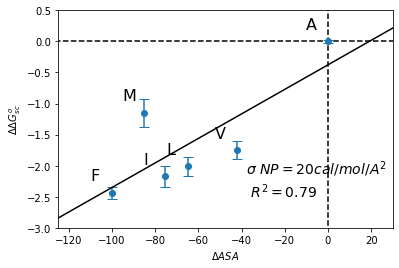

In [12]:
plt.errorbar(delta_np_sasas, deltaGs, yerr=deltaGs_err, fmt='o', capsize=5)
yoffset = 0.2
xoffset = -10
for idx, label in enumerate(labels):
    plt.text(delta_np_sasas[idx]+xoffset, deltaGs[idx]+yoffset, label, fontsize=16)

plt.vlines(0, -10, 10, linestyles='dashed')
plt.hlines(0, -130, 40, linestyles='dashed')
plt.axis([-125, 30, -3, 0.5])
plt.plot(xs, ys, 'k')
plt.xlabel("$\Delta ASA$")
plt.ylabel("$\Delta \Delta G^o _{sc}$")
plt.text(-38, -2.5, f"$\sigma \ NP = {slope*1000:0.0f} cal/mol/A^2$\n $R^2 = {rval:0.2}$", fontsize=14);

For some reason `freesasa` is calculating a different $\Delta ASA$ <br>
only for Methionine than is reported in the reference figure. If I correct this we get the following plot

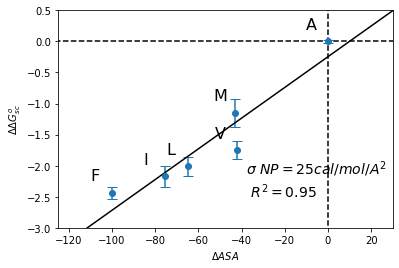

In [13]:
delta_np_sasas_corrected = [x for x in delta_np_sasas]
delta_np_sasas_corrected[4] = -43 #Approximate from reference figure

result = stats.linregress(delta_np_sasas_corrected, deltaGs)
slope = result[0]
intercept = result[1]
rval = result[2]

xs = np.linspace(-130, 30, 1000)
linear_fit = lambda x: slope*x + intercept
ys = linear_fit(xs)

plt.errorbar(delta_np_sasas_corrected, deltaGs, yerr=deltaGs_err, fmt='o', capsize=5)
yoffset = 0.2
xoffset = -10
for idx, label in enumerate(labels):
    plt.text(delta_np_sasas_corrected[idx]+xoffset, deltaGs[idx]+yoffset, label, fontsize=16)
plt.vlines(0, -10, 10, linestyles='dashed')
plt.hlines(0, -130, 40, linestyles='dashed')
plt.axis([-125, 30, -3, 0.5])
plt.plot(xs, ys, 'k')
plt.xlabel("$\Delta ASA$")
plt.ylabel("$\Delta \Delta G^o _{sc}$")
plt.text(-38, -2.5, f"$\sigma \ NP = {slope*1000:0.0f} cal/mol/A^2$\n $R^2 = {rval:0.2}$", fontsize=14);

### Question 3

Read in data which corresponds to the copied table 1 from the paper exported to .csv from excel

In [14]:
pagp_energies = {}
pagp_err = {}
pagp_ompla_diff = {}
pagp_ompla_diff_err = {}
with open("data.csv", "r") as f:
    for i in f.readlines():
        i = i.strip().split(',')
        resn = i[0][-1:]
        
        pagp_energies[resn] = float(i[5])
        pagp_err[resn] = float(i[6])
        pagp_ompla_diff[resn] = float(i[-2])
        pagp_ompla_diff_err[resn] = float(i[-1])
        
resis = list(pagp_energies.keys())
pagps = [pagp_energies[x] for x in resis]
pagps_err = [pagp_err[x] for x in resis]
diff = [pagp_ompla_diff[x] for x in resis]
diff_err = [pagp_ompla_diff_err[x] for x in resis]

omplas = [y - x for x,y in zip(diff, pagps)]
omplas_err = [abs(y - x) for x,y in zip(diff_err, pagps_err)]
print(resis)
print(pagps)
print(omplas)
print(omplas_err)

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
[-1.73, -2.45, 0.77, -0.54, -4.17, -0.09, 1.6, -3.9, 1.81, -3.74, -2.88, 1.22, 2.09, 0.81, 1.49, 0.11, -0.78, -3.48, -3.93, -2.75]
[-1.57, -1.08, 1.38, 0.06999999999999995, -3.77, 0.15, 3.1900000000000004, -3.12, 3.82, -3.3200000000000003, -2.33, 1.91, -3.09, 1.44, 2.14, 0.26, 0.20999999999999996, -2.34, -1.9500000000000002, -2.66]
[0.0, 0.10999999999999999, 0.11000000000000001, 0.04999999999999999, 0.21000000000000002, 0.05, 0.16000000000000003, 0.23, 0.45, 0.06, 0.07000000000000003, 0.25, 0.07, 0.08, 0.08000000000000002, 0.18, 0.29000000000000004, 0.19, 0.19, 0.019999999999999962]


Create a linear regression of the ompla vs pagp data while masking out proline since it is an outlier.

In [15]:
index = np.where(np.array(resis) == "P")[0]

masked_resis = [x for idx, x in enumerate(resis) if idx != index]
masked_omplas = [x for idx, x in enumerate(omplas) if idx != index]
masked_pagps = [x for idx, x in enumerate(pagps) if idx != index]

result = stats.linregress(masked_omplas, masked_pagps)
slope = result[0]
intercept = result[1]
rval = result[2]

xs = np.linspace(-5, 5, 1000)
linear_fit = lambda x: slope*x + intercept
ys = linear_fit(xs)

Calculate the confidence interval of the linear fit

In [16]:
def standard_err_of_estimate(xvals, yvals, slope, intercept, n):
    _sum = 0
    for x,y in zip(xvals, yvals):
        calc_Y = slope*x + intercept
        _sum = (y - calc_Y) ** 2
    denominator = n - 2
    return np.sqrt(_sum/denominator)
        

def standard_err_of_regression_line(x, xvals, yvals, slope, intercept):
    n = len(xvals)
    xbar = sum(xvals)/n
    numerator = (x - xbar) ** 2
    denominator = sum([(x - xbar) **2 for x in xvals])
    sigma_y = standard_err_of_estimate(xvals, yvals, slope, intercept, n)
    return sigma_y * np.sqrt((1/n) + (numerator / denominator))

errs = np.array([standard_err_of_regression_line(x, omplas, pagps, slope, intercept) for x in xs])
y_95 = stats.t.ppf(0.95, df=len(omplas)-2) * errs

Create plot of ompla vs pagp free energy data.

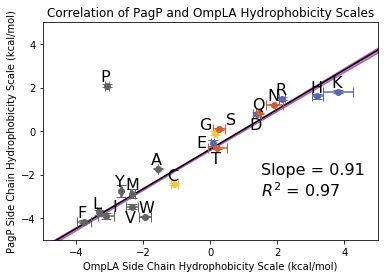

In [17]:
fig, ax = plt.subplots()

##Confidence interval
ax.plot(xs, ys, 'k')
ax.fill_between(xs, (ys-y_95), (ys+y_95), color='purple', alpha=0.5)

##Points with error bars
for idx, o in enumerate(omplas):
    ax.errorbar(o, pagps[idx], xerr=omplas_err[idx], yerr=pagps_err[idx], fmt='o', color=ddGsc_color[resis[idx]], capsize=5)
    
##Add data labels
for idx, label in enumerate(resis):
    yoffset = 0.2
    xoffset = -0.2
    if label in ["T", "D", "V"]:
        yoffset=-0.7
    if label in ["I"]:
        xoffset=0.2
    if label in ["G"]:
        xoffset=-0.5
    if label in ["S"]:
        xoffset=+0.2
    if label in ["E"]:
        yoffset=-0.2
        xoffset=-0.5
    ax.text(omplas[idx]+xoffset, pagps[idx]+yoffset, label, fontsize=16)

#Add parameter findings.
ax.text(1.5, -3, f"Slope = {slope:0.2f}\n$R^2$ = {rval:0.2f}", fontsize=16)
plt.xlabel("OmpLA Side Chain Hydrophobicity Scale (kcal/mol)")
plt.ylabel("PagP Side Chain Hydrophobicity Scale (kcal/mol)")
plt.title("Correlation of PagP and OmpLA Hydrophobicity Scales")

ax.axis([-5, 5, -5, 5]);

### Question 4

Read the sequence from the fasta file into a string and calculate hydrophobicity for each position using the reference free ddGsc values.

In [18]:
sequence = ""
with open("mySeq.fasta", "r") as f:
    for idx, i in enumerate(f.readlines()):
        if idx == 0:
            continue
        i = i.strip()
        sequence += i
hydrophobicity = [ddGsc[x] for x in sequence]

Calculate the hydrophobicities as directed using the sliding window method and correct with energy of peptide bond transfer

In [19]:
window_size = 19

head = list(np.zeros(9))
tail = list(np.zeros(9))

hydrophobicities = head
for idx in range(len(sequence)-window_size+1):
    hydrophobicities.append(sum([hydrophobicity[idx] for idx in range(idx, idx+window_size)]))
hydrophobicities.extend(tail)

print("idx 10: ", hydrophobicities[9])
print("idx 11: ", hydrophobicities[10])
print("idx 338: ", hydrophobicities[337])
print("idx 339: ", hydrophobicities[338])

energy_of_peptide_bond_transfer = 1.6 * window_size
corrected_hydrophobicities = [x + energy_of_peptide_bond_transfer if x != 0 else 0 for x in hydrophobicities]

predicted_helices = []
for idx, i in enumerate(corrected_hydrophobicities):
    index = idx + 1
    if i < 0:
        predicted_helices.append(index)
        
pred_helix_list = []
temp = []
prev = predicted_helices[0] - 1
for i in predicted_helices:
    if prev+1 != i:
        pred_helix_list.append(temp)
        temp = []
    temp.append(i)
    prev = i
pred_helix_list.append(temp) 

print(pred_helix_list)

idx 10:  -13.54
idx 11:  -14.14
idx 338:  -8.13
idx 339:  -9.770000000000001
[[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57], [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97], [108], [110, 111, 112], [117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139], [154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170], [204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228], [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272], [274], [279, 280, 281], [291, 292], [295, 296, 297, 298, 299, 300, 301], [313, 314]]


Create plot of initial hydrophobicity values.

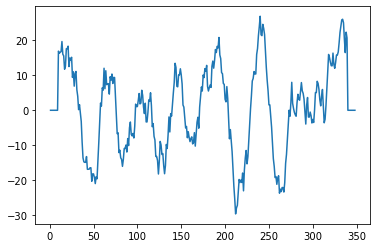

In [20]:
plt.plot(range(1, 349), corrected_hydrophobicities);

Identify transmembrane helices from pymol helix output.

In [21]:
helix_regions = []
with open("helix.txt", "r") as f:
    prev = 27
    temp = []
    for i in f.readlines():
        i = int(i.strip())
        if prev+1 != i:
            helix_regions.append(temp)
            temp = []
        temp.append(i)
        prev = i
    helix_regions.append(temp)
print(helix_regions)

[[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101], [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140], [149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173], [199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226], [245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278], [284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,

Create final, well-formatted plot of hydrophobicity with predicted and known transmembrane helix regions.

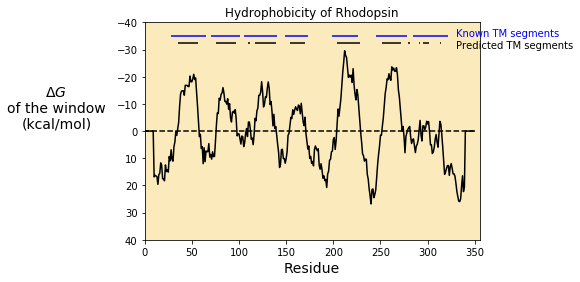

In [22]:
fig, ax = plt.subplots()
plt.plot(range(1, 349), [x for x in corrected_hydrophobicities], 'k')
plt.hlines(0, 350, 0, linestyles="dashed")
plt.axis([0, 355, -40, 40])
background_color = [x/255 for x in (251, 234, 187)]
ax.set_facecolor(background_color)
ax.set_ylim(ax.get_ylim()[::-1])

##Plot known TM segments
for i in helix_regions:
    ax.hlines(-35, i[0], i[-1], color="blue")
plt.text(348-18, -35, "Known TM segments", color="blue")

##Plot predicted TM segments
for i in pred_helix_list:
    ax.hlines(-32.5, i[0], i[-1], color="k")
plt.text(348-18, -30.5, "Predicted TM segments")

h = plt.ylabel("")
ax.set_ylabel('$\Delta G$ \nof the window\n(kcal/mol)', rotation=0, fontsize=14, labelpad=60)
ax.set_xlabel('Residue', fontsize=14)
plt.title("Hydrophobicity of Rhodopsin")

h.set_rotation(0)